# Setup

In [1]:
!pip install -Uqq kaggle
!pip install -Uqq fastai
!pip install -Uqq nbdev 
!pip install -Uqq wandb
!pip install -Uqq numpy pandas scipy 
!pip install -Uqq matplotlib seaborn

In [1]:
import os
from getpass import getpass

os.environ['KAGGLE_USERNAME'] = getpass('Kaggle username:')
os.environ['KAGGLE_KEY'] = getpass('Kaggle token:')

In [ ]:
!kaggle datasets download -d ankursingh12/resized-plant2021
!unzip resized-plant2021.zip

In [2]:
import wandb
from getpass import getpass

wandb_username = getpass('wandb user:')
wandb_token = getpass('wandb token:')

!wandb login --relogin $wandb_token

wandb: Appending key for api.wandb.ai to your netrc file: /home/studio-lab-user/.netrc


In [3]:
wandb.init(project="DI504", entity=wandb_username)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bdsaglam (use `wandb login --relogin` to force relogin)


# Definitions

In [4]:
def reset_gpu_memory():
    import torch
    torch.cuda.reset_max_memory_cached()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_accumulated_memory_stats()

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

In [39]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from pathlib import Path
Path('./figures').mkdir(parents=True, exist_ok=True)

plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 300


def savefig(fname, **kwargs):
    params = dict(bbox_inches='tight', transparent="True", pad_inches=0)
    params.update(kwargs)
    plt.savefig(f'./figures/{fname}', **params)


# Data

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd



from fastai.vision.all import *
from fastai.callback.wandb import *

In [6]:
def drop_missing_paths(df):
    mask = df['path'].apply(lambda fp: not Path(fp).exists())
    print(f"{sum(mask)} files missing")
    return df.drop(axis=0, index=df.index[mask])

In [7]:
data_dir = Path('./')

PRESIZE = 512
train_img_dir = data_dir / f'img_sz_{PRESIZE}'
train_label_file = data_dir / 'train.csv'

In [8]:
df = (
    pd.read_csv(train_label_file, low_memory=False)
        .assign(path=lambda dataf: dataf['image'].apply(lambda fname: str(train_img_dir / fname)))
#         .pipe(drop_missing_paths)
)
print(df.shape)
df.head()

(18632, 3)


image                           labels  \
0  800113bb65efe69e.jpg                          healthy   
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex   
2  80070f7fb5e2ccaa.jpg                             scab   
3  80077517781fb94f.jpg                             scab   
4  800cbf0ff87721f8.jpg                          complex   

                              path  
0  img_sz_512/800113bb65efe69e.jpg  
1  img_sz_512/8002cb321f8bfcdf.jpg  
2  img_sz_512/80070f7fb5e2ccaa.jpg  
3  img_sz_512/80077517781fb94f.jpg  
4  img_sz_512/800cbf0ff87721f8.jpg

## Data quality

In [9]:
duplicate_pairs = [
                 line.split(", ")  for line in """
abf0b5a0df028b17.jpg, abf0b5819f028f0f.jpg
e22e8a365cd1ea5c.jpg, e22e9a365cd1ea58.jpg
83e3d2369933c5d2.jpg, 83e3d2329933c5f2.jpg
8f5263c61a8cdbe2.jpg, c9d63696629107ed.jpg
cdf892b5b4865859.jpg, 82ba3e933947b097.jpg
eec64e8cf1c8d0c6.jpg, e51690d8ad307dcb.jpg
ba99260ef46b18cb.jpg, b7b0edd58a858217.jpg
ec83c7c04a1e9db9.jpg, 85897ea7f064b26a.jpg
df90901ccb664de6.jpg, 8c0731fff680c51e.jpg
d7ec32d72c84dc18.jpg, 9fad869f21b5b240.jpg
9ada65c5b0cc9a3c.jpg, e9e8ad35c5871d06.jpg
abb0d5a9d4b4985c.jpg, ab91d1a9d4b49a6c.jpg
848d9f9e82d18e5e.jpg, 949b6595a5b8ca3c.jpg
e90e1ac8b7e7aa50.jpg, e90e1acab7e5aa50.jpg
94c83b2d5fad6924.jpg, 90f99ee1c1132bb6.jpg
90a5341f227ce5f9.jpg, f3dc17a2b20d48ec.jpg
dfbdc047068b063d.jpg, cebdc20f67838631.jpg
e5f27342ce1cb9a0.jpg, ca782c131f5ce0fc.jpg
ebd19f9c549a12d0.jpg, ebd19f1c549a1ad0.jpg
e11be7f110de8f80.jpg, e13be7f1105e8f80.jpg
d1dec0973c2cf4a1.jpg, d2d9c2bca7a72458.jpg
c1753cad2f31d492.jpg, d2266ac99461e9db.jpg
d0c766bc38e1978c.jpg, e83f715e56462a31.jpg
9886c704f93a79b3.jpg, 98864714f96a75d5.jpg
ae5074cfc9183763.jpg, 965295a64a97859f.jpg
d70f6330fb5a090d.jpg, d70f2230fb5a093d.jpg
f196f11a99d91ce0.jpg, f392f11919991cea.jpg
f90738a0d2f2c1db.jpg, bd8088cdad5f65e0.jpg
af6292db1b611d98.jpg, a56292dadb618d95.jpg
cc73e025cc36d31e.jpg, cc73e005cc36f31e.jpg
aa542048ebf78bf4.jpg, aa142048eff78bf4.jpg
c5339e87235c6ac5.jpg, c53b9e87215c6ac5.jpg
e586c25e0f1c3c79.jpg, e787c35e0f0c34e8.jpg
d1f01e8d8a73274d.jpg, a9b2e4b09297bc2b.jpg
e8bd8ac4d982dd83.jpg, e8a58ad4d9829f33.jpg
c738d13e7146798c.jpg, c738d13e73467988.jpg
9fc321ce60a69f0b.jpg, 86f963a16e70345e.jpg
b5ec52491e3349ce.jpg, a7e613159fb22859.jpg
c335971e8acd609e.jpg, e385830ecacd2d9e.jpg
f7d233d11aa8496c.jpg, 94b42695f24dad36.jpg
e9c39fa809c7341d.jpg, e1e39f8809c7349d.jpg
8dbeda49894d522e.jpg, afbe5641896d522a.jpg
e7ecc583d571d202.jpg, a3bb604d8a55995d.jpg
b80898e11f81ff1f.jpg, b80898e11fa17f1f.jpg
ab83c0d147c3db66.jpg, ab83c05147c3cfe6.jpg
a8e895f5aa54d2a5.jpg, a8e895e5aad453a5.jpg
dfcc6b28063a88fc.jpg, dfc86b180e3ac8f8.jpg
f0cb879e4a1b35c1.jpg, f0cb859beb1b30c1.jpg
d89d9ede82743229.jpg, d89c9cda9274322f.jpg
f2c798246a0a9bdd.jpg, c1a56069de75b899.jpg
aa0e969518e15d3f.jpg, bb1891fa8c61e663.jpg
f6f1160be38a48d5.jpg, f6f11e0fe38a08c5.jpg
f4cba4a7294d6585.jpg, d64460a3b19f1cfc.jpg
dbee22785d9285c4.jpg, c5aff2e545d0a129.jpg
d3945c098edc9dd1.jpg, dea33c5c0347aa4d.jpg
e8210ddefc024fec.jpg, e8212ddeec024fec.jpg
""".splitlines() if line ]

idf = df.set_index('image')
duplicates = [((a, idf.loc[a, 'labels']), (b, idf.loc[b, 'labels'])) for a, b in duplicate_pairs]

def pick_worse_label(duplicates):
    for a, b in duplicates:
        if a[1]==b[1]:
            yield a[0]
        if a[1] == 'complex':
            yield b[0]
        if b[1] == 'complex':
            yield a[0]
        
        if len(a[1].split()) > len(b[1].split()):
            yield b[0]
        
        yield a[0]

images_dropped = list(pick_worse_label(duplicates))
df = idf.drop(index=images_dropped).reset_index()
df

image                           labels  \
0      800113bb65efe69e.jpg                          healthy   
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex   
2      80070f7fb5e2ccaa.jpg                             scab   
3      80077517781fb94f.jpg                             scab   
4      800cbf0ff87721f8.jpg                          complex   
...                     ...                              ...   
18559  fffb900a92289a33.jpg                          healthy   
18560  fffc488fa4c0e80c.jpg                             scab   
18561  fffc94e092a59086.jpg                             rust   
18562  fffe105cf6808292.jpg          scab frog_eye_leaf_spot   
18563  fffe472a0001bd25.jpg                          healthy   

                                  path  
0      img_sz_512/800113bb65efe69e.jpg  
1      img_sz_512/8002cb321f8bfcdf.jpg  
2      img_sz_512/80070f7fb5e2ccaa.jpg  
3      img_sz_512/80077517781fb94f.jpg  
4      img_sz_512/800cbf0ff87721f8.jpg  
...                                ...  
18559  img_sz_512/fffb900a92289a33.jpg  
18560  img_sz_512/fffc488fa4c0e80c.jpg  
18561  img_sz_512/fffc94e092a59086.jpg  
18562  img_sz_512/fffe105cf6808292.jpg  
18563  img_sz_512/fffe472a0001bd25.jpg  

[18564 rows x 3 columns]

## Data distribution

In [10]:
from collections import Counter

def percentify(counter):
    total = sum(v for k,v in counter.items())
    return Counter({k: v/total for k,v in counter.items()})

all_labels = [label for labels in df['labels'].values for label in labels.split()]
sample_counter = Counter(all_labels)
rate_counter = percentify(sample_counter)

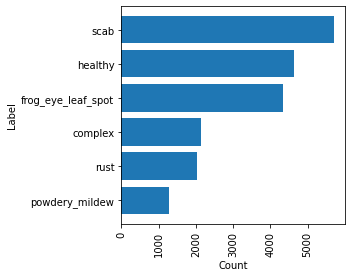

In [11]:
cntr = sample_counter
plt.figure(figsize=(4,4))
plt.barh(*list(zip(*sorted(list(cntr.items()), key=lambda t: t[1], reverse=False))))
plt.xlabel('Count')
plt.ylabel('Label')
plt.xticks(rotation=90);

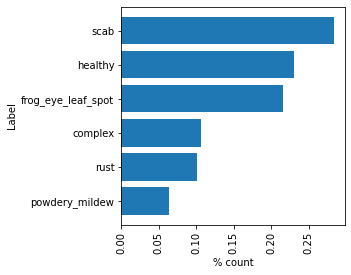

In [12]:
cntr = rate_counter
fig = plt.figure(figsize=(4,4))
plt.barh(*list(zip(*sorted(list(cntr.items()), key=lambda t: t[1], reverse=False))))
plt.xlabel('% count')
plt.ylabel('Label')
plt.xticks(rotation=90);

# Datablock

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


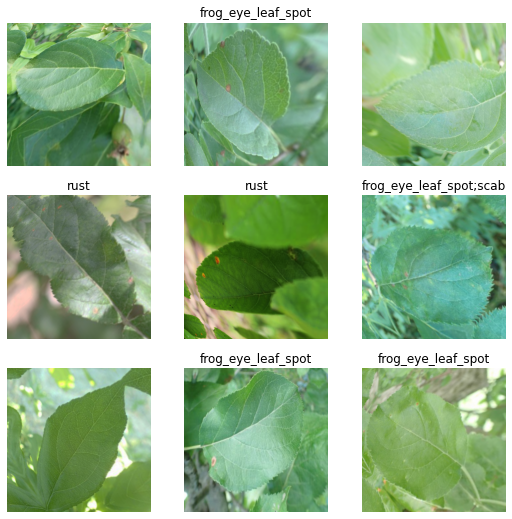

In [13]:
VOCAB = ['complex','frog_eye_leaf_spot', 'powdery_mildew','rust','scab']

IMG_SIZE=384
valid_pct = 0.2
bs = 64

augmentation_params = dict(
    mult=2.0, 
    do_flip=True, 
    flip_vert=True, 
    max_rotate=30.0, 
    min_zoom=0.9, 
    max_zoom=1.1, 
)

def get_x(row):
    return PILImage.create(row['path'])

def get_y(r): 
    labels = r['labels'].split(' ')
    if 'healthy' in labels:
        return []
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(vocab=VOCAB)),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(size=IMG_SIZE, min_scale=1.0),
    batch_tfms=[
        *aug_transforms(**augmentation_params),
        Normalize.from_stats(*imagenet_stats)
    ]
)

dls = dblock.dataloaders(df, bs=bs)

dls.show_batch()

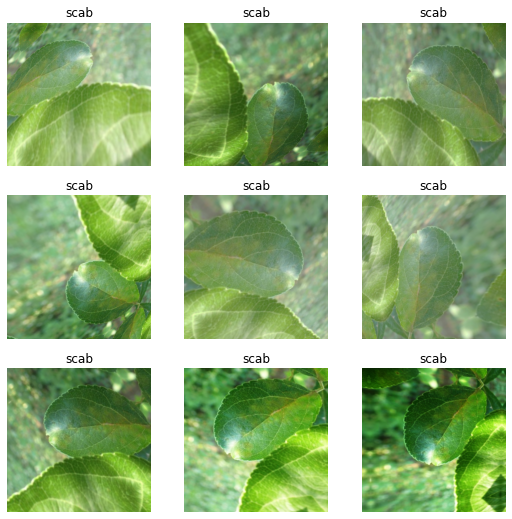

In [14]:
dls.show_batch(unique=True)

# Loss Functions

In [94]:
class FocalLossBinary(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2, weight=None, reduction= 'mean', thresh=0.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = None if weight is None else torch.tensor([weight], dtype=torch.float, requires_grad=False, device='cuda')
        self.reduction = reduction
        self.thresh = 0.5
        self.eps = 1e-12 # prevent training from Nan-loss error

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        log_pt = target * torch.log(probs + self.eps) + (1.0 - target) * torch.log(1.0 - probs + self.eps)
        focal_loss = -1.0 * (self.alpha * (1 - torch.exp(log_pt)) ** self.gamma) * log_pt
        if self.weight is not None:
            focal_loss = focal_loss * self.weight
        if self.reduction == 'sum':
            return torch.sum(focal_loss)
        
        return torch.mean(focal_loss)
    
    def decodes(self, x):    
        return x > self.thresh

    def activation(self, x): 
        return torch.sigmoid(x)
    
pos_weight = [2.18, 1.5, 3.65, 2.3, 1]

In [19]:
from torch.nn.modules.loss import BCEWithLogitsLoss

class PosWeightFactory:
    def __init__(self, dls):
        self.dls = dls
        self.y_enc = None
    
    def make_pos_weight(self, target_pos_rate_map):
        if self.y_enc is None:
            self.setups()
        
        target_pos_rate = torch.tensor(
            [target_pos_rate_map[k] for k in self.dls.vocab], 
            dtype=torch.float
        )
        pos_rate = torch.tensor((self.y_enc.float().sum(dim=0) / self.y_enc.shape[0]).numpy())
        return target_pos_rate / pos_rate
    
    def setups(self):
        y_pipeline = Pipeline(self.dls.train_ds.encodes[1])
        ys = self.dls.train_ds.items.apply(y_pipeline, axis=1).values.tolist()
        self.y_enc = torch.stack(ys).detach().clone()
        return self

pwf = PosWeightFactory(dls).setups()
target_pos_rate_map = {
    'complex': 0.3,
    'frog_eye_leaf_spot': 0.3,
    'powdery_mildew': 0.3,
    'rust': 0.3,
    'scab': 0.3,
}
pos_weight = pwf.make_pos_weight(target_pos_rate_map)
pos_weight

# Training

In [29]:
reset_gpu_memory()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/cuda/memory.py:297: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [15]:
wandb.config.update(dict(
    seed=SEED,
    vocab=VOCAB,
    presize=PRESIZE,
    img_size=IMG_SIZE, 
    valid_pct=valid_pct,
    augmentation_params=augmentation_params,
))

In [41]:
from fastai.vision.models.xresnet import xse_resnext50

from torchvision.models import efficientnet_b0
model_meta[efficientnet_b0] = {'cut': -1, 'split': default_split, 'stats': imagenet_stats}

from torchvision.models import efficientnet_b2
model_meta[efficientnet_b2] = {'cut': -1, 'split': default_split, 'stats': imagenet_stats}

from torchvision.models import efficientnet_b3
model_meta[efficientnet_b3] = {'cut': -1, 'split': default_split, 'stats': imagenet_stats}

from torchvision.models import efficientnet_b5
model_meta[efficientnet_b5] = {'cut': -1, 'split': default_split, 'stats': imagenet_stats}

In [16]:
def attach_name(metric, name):
    old_func = metric.func
    def func(*args, **kwargs):
        return old_func(*args, **kwargs)
    func.__name__ = name
    metric.func = func
    return metric

In [17]:
f1_macro_metric = attach_name(F1ScoreMulti(thresh=0.5, average='macro'), 'f1_macro')
f1_samples_metric = attach_name(F1ScoreMulti(thresh=0.5, average='samples'), 'f1_samples')

learn = cnn_learner(
    dls, 
    arch=resnet18,
    pretrained=True,
    # loss_func=FocalLossBinary(weight=pos_weight),
    metrics=[partial(accuracy_multi, thresh=0.5), f1_macro_metric, f1_samples_metric], 
    cbs=[WandbCallback(), SaveModelCallback()],
).to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

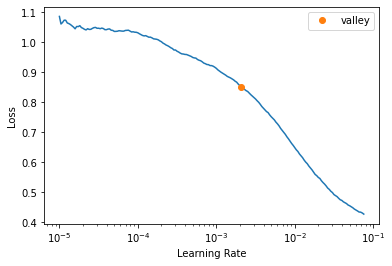

In [18]:
learn.lr_find(start_lr=1e-05, end_lr=1e-1, num_it=200)

In [19]:
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=5)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 0 with valid_loss value: 0.47658780217170715.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 1 with valid_loss value: 0.233584463596344.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 2 with valid_loss value: 0.19098205864429474.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 3 with valid_loss value: 0.16197878122329712.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 4 with valid_loss value: 0.14334142208099365.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 0 with valid_loss value: 0.12267093360424042.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 1 with valid_loss value: 0.11102013289928436.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 2 with valid_loss value: 0.10249219089746475.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 3 with valid_loss value: 0.09377987682819366.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 4 with valid_loss value: 0.09062622487545013.


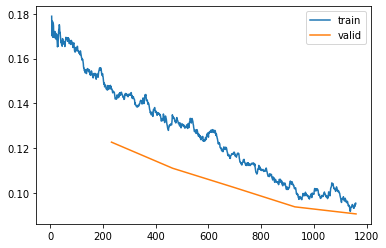

In [20]:
learn.recorder.plot_loss()

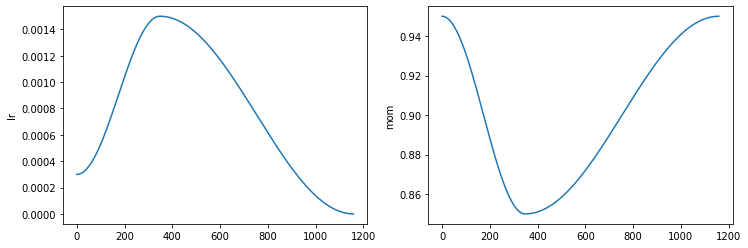

In [21]:
learn.recorder.plot_sched()

# Evaluation

In [22]:
def pick_threshold(preds, targets, metrics, threshold_range=np.arange(0, 1, 0.05), weight=None):
    plt.figure(figsize=(8, 4))
    if weight is None:
        weight = [1.0] * len(metrics)
    weight = (np.array(weight) / np.sum(weight)).reshape(len(metrics), -1)
    
    scores = np.array([
        [metric(preds, targets, threshold) for threshold in threshold_range]
        for metric in metrics
    ])
    wavg_scores = (scores * weight).sum(axis=0)
    plt.plot(threshold_range, scores.T, label=[f"Metric - {i}" for i in list(range(len(metrics)))])
    plt.plot(threshold_range, wavg_scores.T, label='weighted avg', linewidth=2)
    plt.legend(loc='best')
    
    best_idx = wavg_scores.argmax()
    best_threshold =  threshold_range[best_idx]
    best_score =  wavg_scores[best_idx]
    
    plt.plot([best_threshold], [best_score], 'ro')
    for metric in metrics:
        plt.plot([best_threshold], [metric(preds, targets, best_threshold)], 'ko')
    return best_threshold

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

0.58

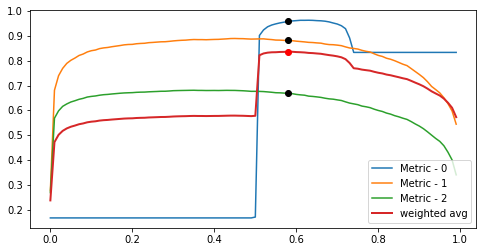

In [23]:
preds, targets = learn.get_preds()

f1_multi_macro = lambda preds, targets, threshold: F1ScoreMulti(sigmoid=False, average='macro')((preds > threshold).float(), targets)
f1_multi_sample = lambda preds, targets, threshold: F1ScoreMulti(sigmoid=False, average='samples')((preds > threshold).float(), targets)

thresh = pick_threshold(preds, targets, [accuracy_multi, f1_multi_macro, f1_multi_sample], np.arange(0,1,0.01))
thresh

In [24]:
rocAuc = RocAucMulti(sigmoid=False)(preds, targets)
acc = accuracy_multi(preds, targets, thresh=thresh)
f1_macro = F1ScoreMulti(sigmoid=False, average='macro')((preds > thresh).float(), targets)
f1_micro = F1ScoreMulti(sigmoid=False, average='micro')((preds > thresh).float(), targets)
f1_samples = F1ScoreMulti(sigmoid=False, average='samples')((preds > thresh).float(), targets)

print(f"ROC AUC  : {rocAuc:.4f}")
print(f"Accuracy : {acc:.4f}")
print(f"F1 Macro : {f1_macro:.4f}")
print(f"F1 Micro : {f1_micro:.4f}")
print(f"F1 Sample: {f1_samples:.4f}")

ROC AUC  : 0.9875
Accuracy : 0.9587
F1 Macro : 0.8816
F1 Micro : 0.8840
F1 Sample: 0.6683


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [25]:
wandb.log({'threshold': thresh})

In [26]:
wandb.finish()

In [47]:
learn.metrics = L()

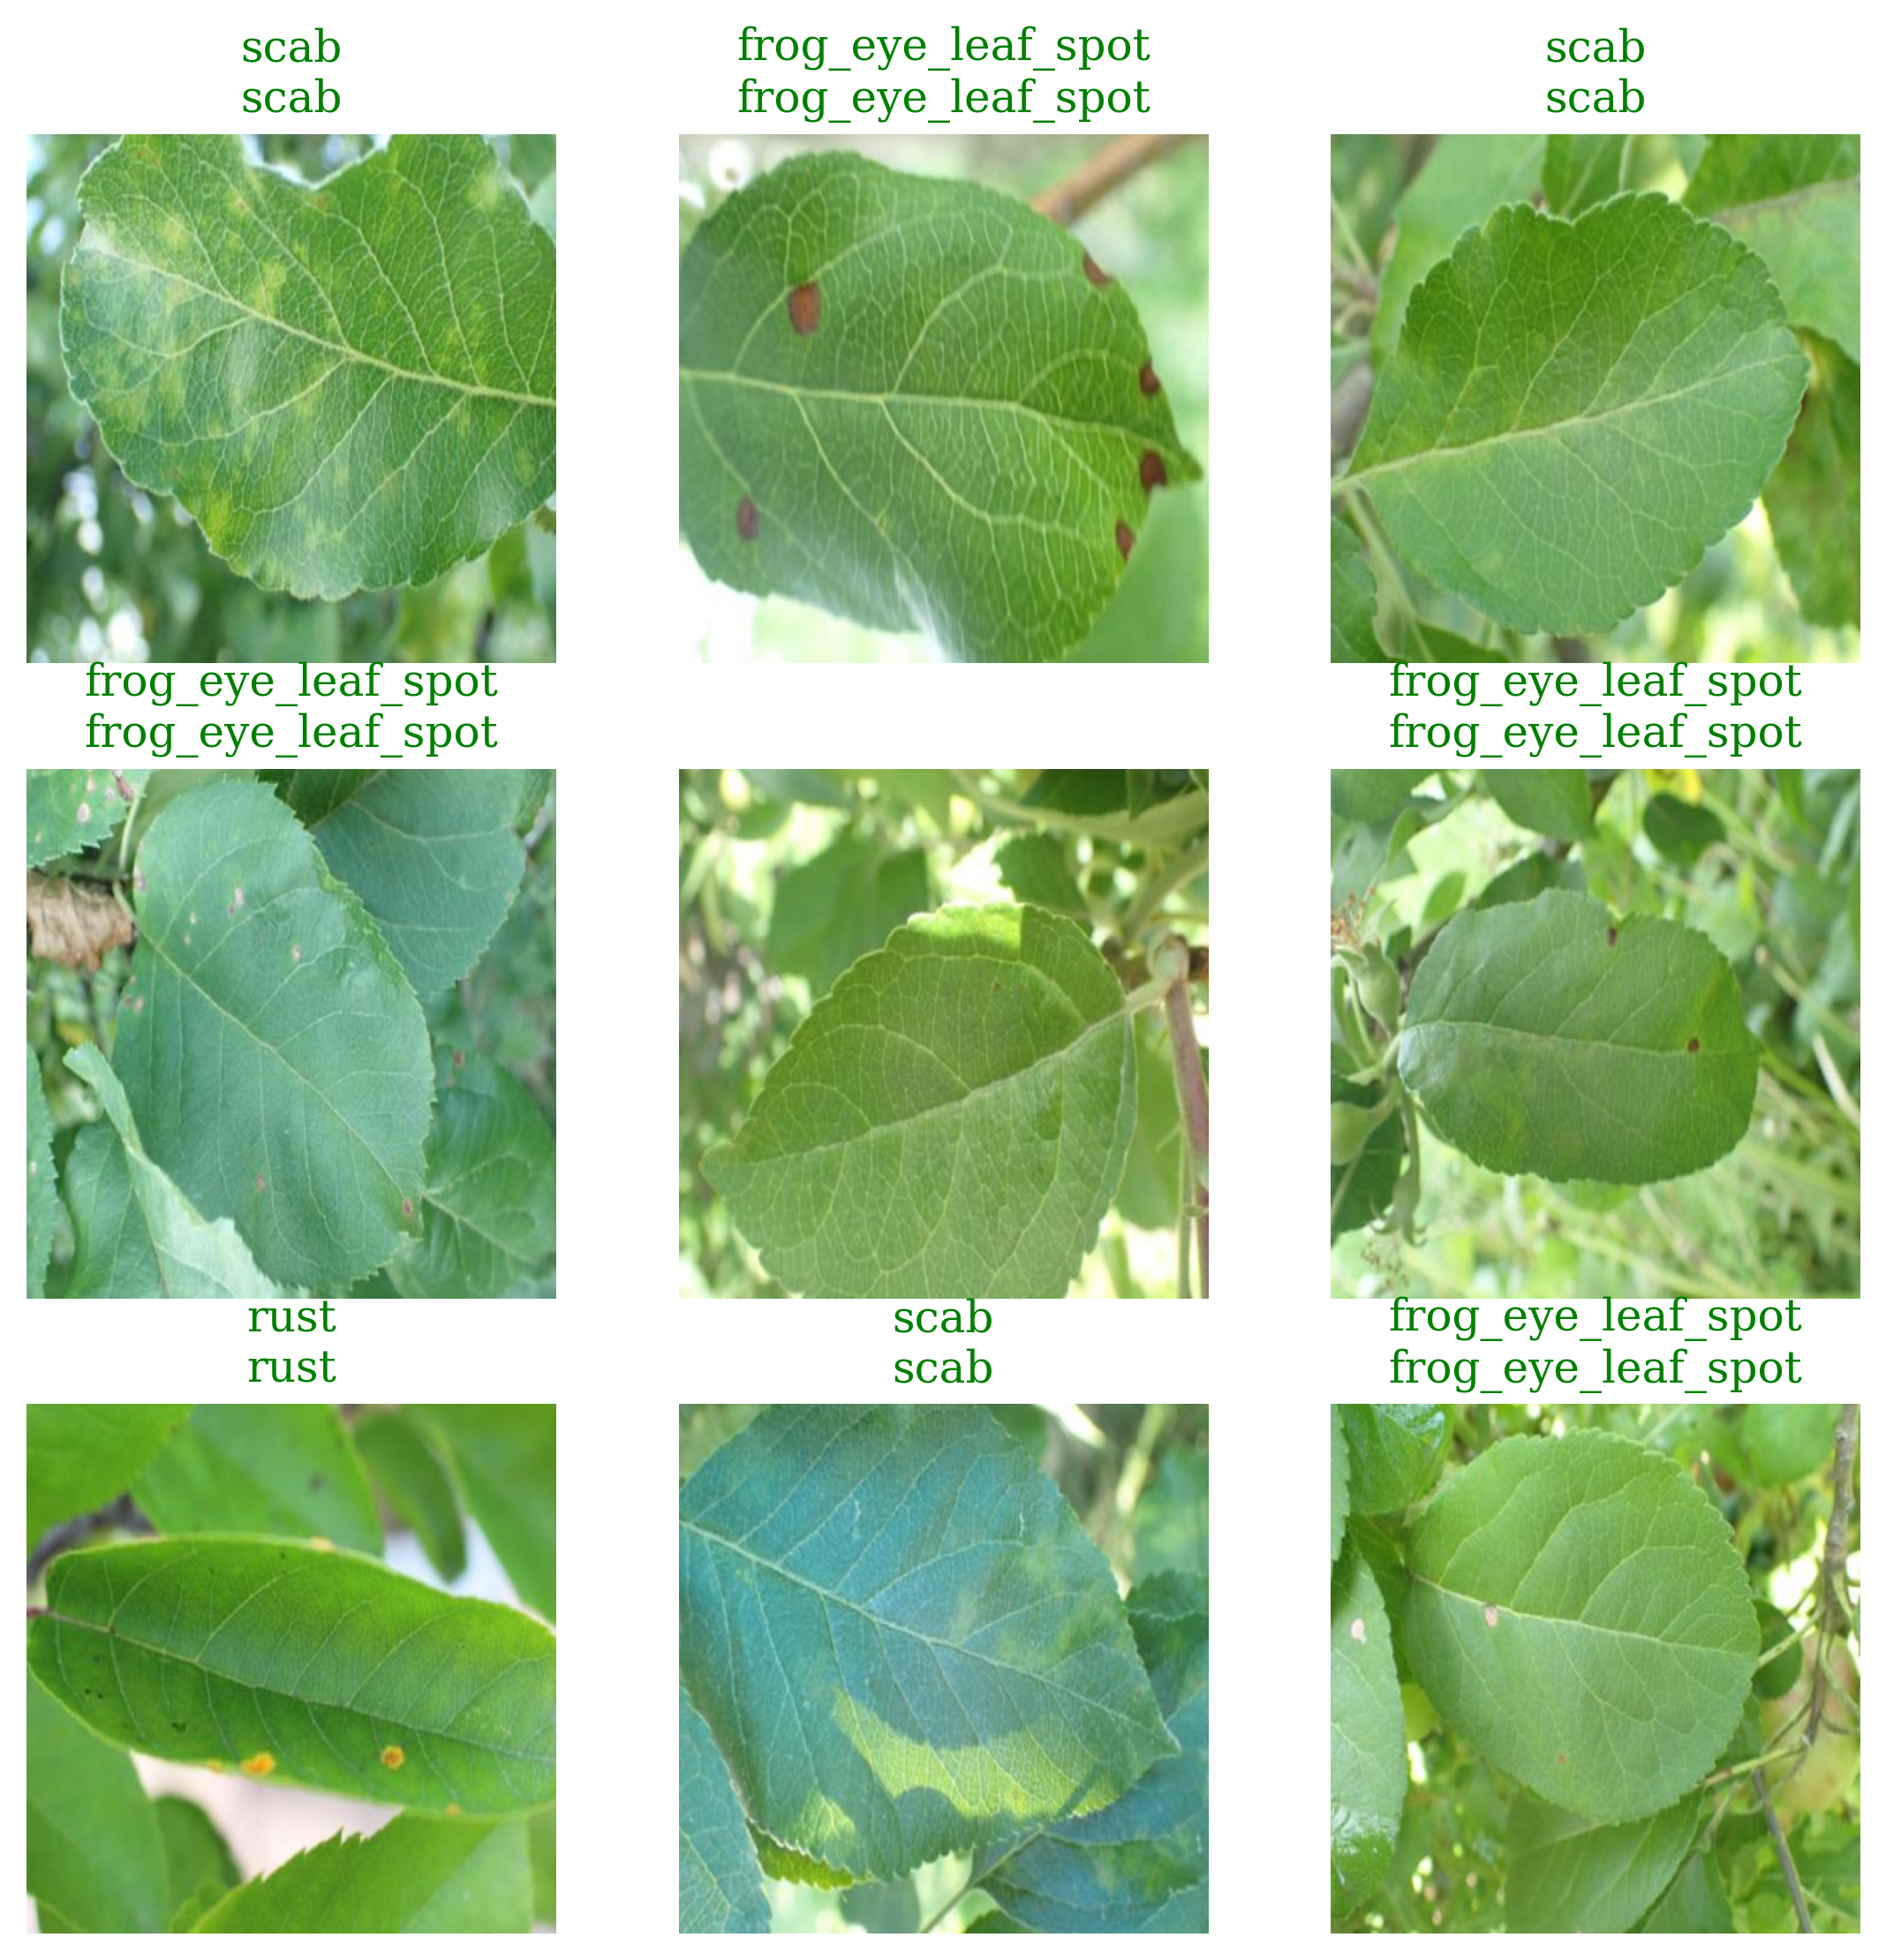

In [48]:
learn.show_results(max_n = 9)

### ROC Curves

In [33]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i,label in enumerate(VOCAB):
    fpr[label], tpr[label], _ = roc_curve(targets[:, i].numpy(), preds[:, i].numpy())
    roc_auc[label] = auc(fpr[label], tpr[label])

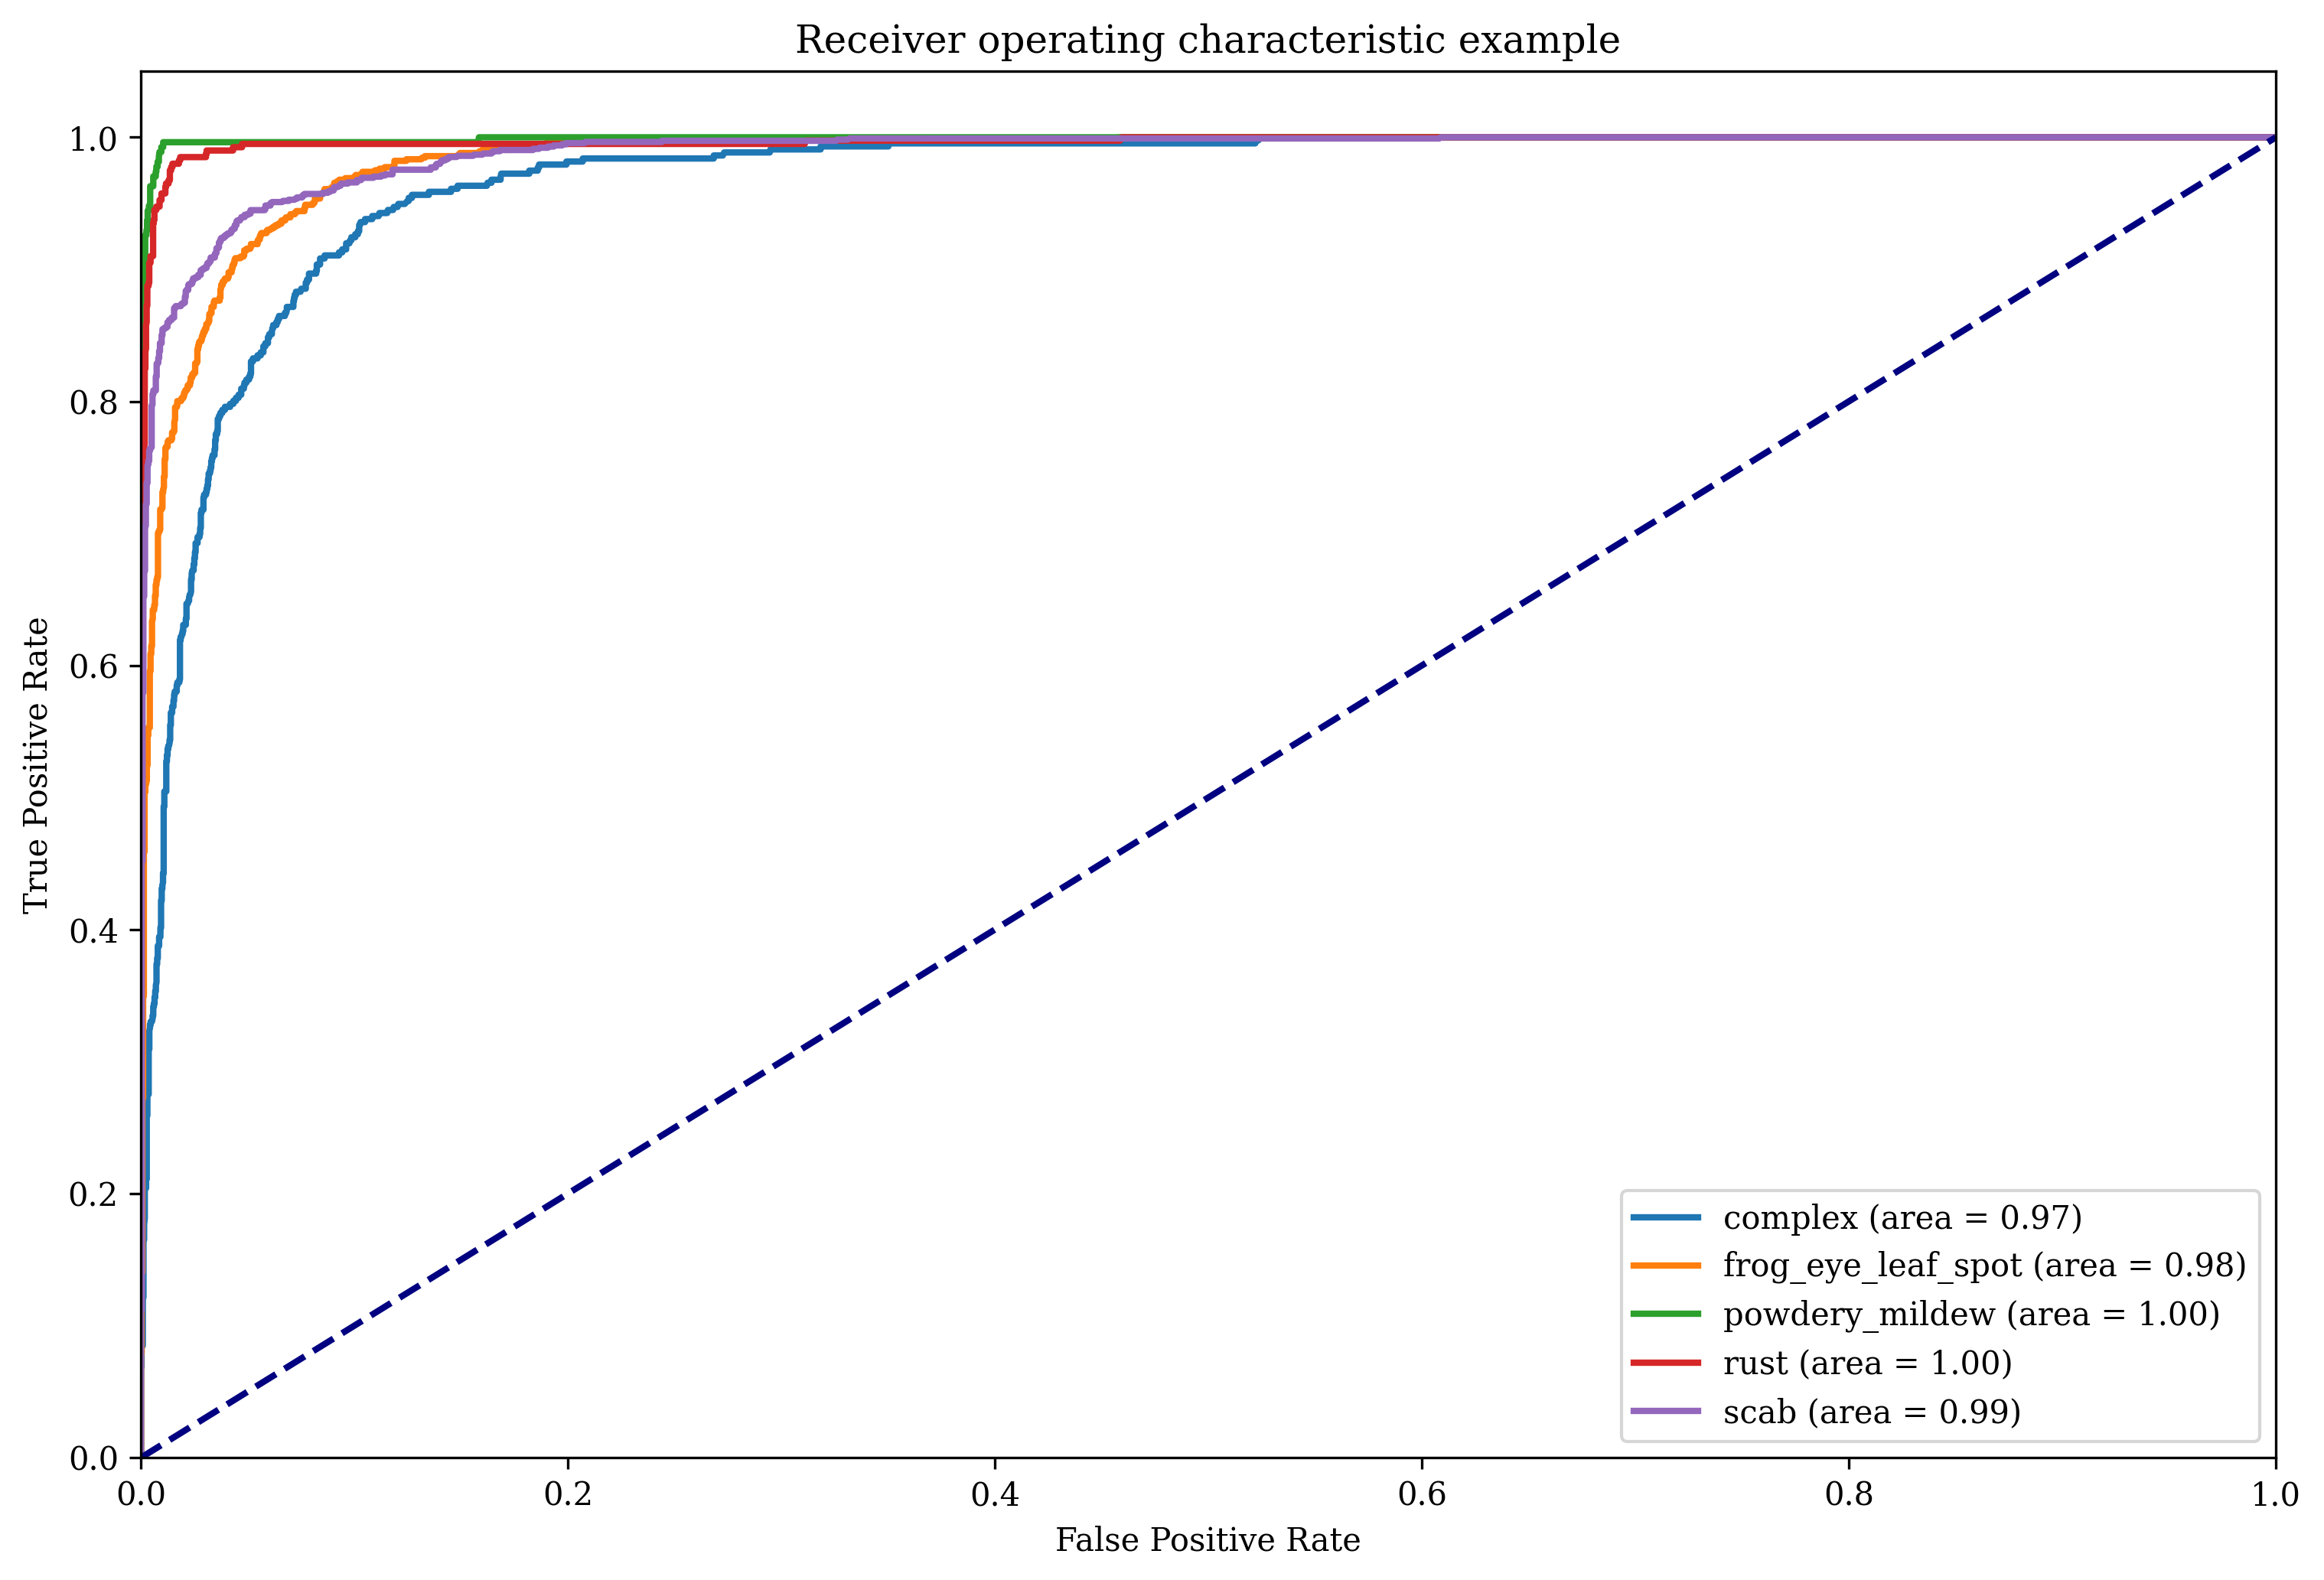

In [41]:
fig = plt.figure(figsize=(12, 8))
for label in VOCAB:
    plt.plot(
        fpr[label],
        tpr[label],
        lw=2,
        label=f"{label} (area = %0.2f)" % roc_auc[label],
    )
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
savefig('rocs.png')
